CELL 1 — Config & load CSVs

In [1]:
import os, time, math, json
import numpy as np
import pandas as pd
from math import ceil
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------- EDIT THESE PATHS to the CSVs you already have (from your repo) ----------
CSV_PATH_USER   = '/content/drive/MyDrive/Colab Notebooks/Dataset/per_user_features_timeaware_pruned11.csv'
CSV_PATH_GLOBAL = '/content/drive/MyDrive/Colab Notebooks/Dataset/global_features_timeaware_pruned11.csv'
# ---------------------------------------------------------------------------------

# If you prefer, set these to local paths instead.
assert os.path.exists(CSV_PATH_USER), f"CSV_PATH_USER not found: {CSV_PATH_USER}"
assert os.path.exists(CSV_PATH_GLOBAL), f"CSV_PATH_GLOBAL not found: {CSV_PATH_GLOBAL}"

# Columns expected to exist in both CSVs:
ID_COLS    = ['user', 'day']
LABEL_COLS = ['is_malicious']  # if your file has more label cols, add them

# --- NEW: Configuration for Rule-Based Re-ranking ---
# These are the specific flags used in your rule logic from the older script.
RULE_FLAG_NAMES = ['wikileaks_flag','offhour_logon_flag','offhour_usb_flag','offhour_http_flag']
RULE_WEIGHTS = {"wikileaks_flag":1.0, "offhour_usb_flag":0.7, "offhour_http_flag":0.3, "offhour_logon_flag":0.3}
HYBRID_WEIGHT_MODEL = 0.7 # The 'w1' weight for the model's anomaly score

# --- NEW: Configuration for SHAP ---
DO_SHAP_MONTHLY = True # Set to True to enable SHAP explanations
TOP_N_FEATURES_SHAP = 5 # How many top features to show in the explanation

# Algorithm settings
RANDOM_STATE = 42
PCT_THRESHOLD = 99  # used in per-user threshold experiments (e.g., 99 => 99th percentile)
MIN_USER_SAMPLES_FOR_PER_USER = 30  # fallback to global if user has fewer benign samples
SHAP_BG_SIZE = 100  # background sample size for SHAP

CELL 2 — Preprocessing: load and basic checks

In [2]:
# Load
df_user = pd.read_csv(CSV_PATH_USER, parse_dates=['day'])
df_global = pd.read_csv(CSV_PATH_GLOBAL, parse_dates=['day'])

# Normalize IDs & drop duplicates
for df in [df_user, df_global]:
    assert 'user' in df.columns and 'day' in df.columns, "Both CSVs must contain 'user' and 'day' columns"
    df['user'] = df['user'].astype(str)
    df['day'] = pd.to_datetime(df['day']).dt.floor('D')
    df.drop_duplicates(subset=['user', 'day'], inplace=True)

# Ensure labels exist
assert all(c in df_user.columns for c in LABEL_COLS), f"Missing label cols {LABEL_COLS} in per-user CSV"
assert all(c in df_global.columns for c in LABEL_COLS), f"Missing label cols {LABEL_COLS} in global CSV"

# --- NEW: Check for rule flag columns in the user dataframe ---
# This is important for the rule score calculation later.
for flag in RULE_FLAG_NAMES:
    if flag not in df_user.columns:
        print(f"Warning: Rule flag column '{flag}' not found in the user CSV. It will be treated as 0.")
        df_user[flag] = 0 # Add the column with zeros if missing

# Intersect keys to keep aligned rows (only keep rows present in both files)
common_keys = pd.merge(df_user[ID_COLS], df_global[ID_COLS], on=ID_COLS)
df_user = df_user.merge(common_keys, on=ID_COLS, how='inner')
df_global = df_global.merge(common_keys, on=ID_COLS, how='inner')

print("Loaded per-user rows:", len(df_user), "global rows:", len(df_global))
print("Unique users:", df_user['user'].nunique())

Loaded per-user rows: 321599 global rows: 321599
Unique users: 960


CELL 3 — Discover feature columns

In [3]:
# auto-discover per-user z columns and global z columns
per_user_z_cols = [c for c in df_user.columns if '_user_z' in c]
global_z_cols   = [c for c in df_global.columns if '_global_z' in c or '_z' in c and c not in per_user_z_cols]

# Fallbacks - if naming differs, print columns to inspect
if len(per_user_z_cols) == 0:
    print("No columns matching '_user_z' found in per-user CSV. Please update naming or edit the filter.")
    print("Sample columns:", df_user.columns.tolist()[:50])
if len(global_z_cols) == 0:
    print("No global z columns auto-detected. Sample columns:", df_global.columns.tolist()[:50])

print(f"Using {len(per_user_z_cols)} per-user features and {len(global_z_cols)} global features.")

Using 34 per-user features and 34 global features.


CELL 4 — Helpers (building X, scoring, metrics)

In [4]:
def _to_numeric_fill0(df):
    return df.apply(pd.to_numeric, errors='coerce').fillna(0.0)

def _build_X(df, cols):
    X = df[cols].copy()
    return _to_numeric_fill0(X)

def _month_start(ts):
    return ts.to_period('M').to_timestamp()

def _month_end_exclusive(ts):
    return (_month_start(ts) + pd.offsets.MonthBegin(1))

def compute_metrics_from_cm(cm):
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    total = tn + fp + fn + tp
    acc = (tn + tp) / total if total > 0 else float('nan')
    pre = (tp / (tp + fp)) if (tp + fp) > 0 else 0.0
    rec = (tp / (tp + fn)) if (tp + fn) > 0 else 0.0
    f1  = (2 * pre * rec / (pre + rec)) if (pre + rec) > 0 else 0.0
    return {'accuracy': acc, 'precision': pre, 'recall': rec, 'f1': f1, 'tn':tn,'fp':fp,'fn':fn,'tp':tp}

def safe_anomaly_scores_from_clf(clf, X):
    """
    Return anomaly score where larger -> more anomalous (consistent across models).
    We try multiple methods and invert where the library definition returns "higher -> normal".
    """
    X_arr = X if isinstance(X, (np.ndarray,)) else X.values
    # Prefer decision_function if present
    score = None
    try:
        # sklearn decision_function: higher -> more normal for many models -> invert
        df = clf.decision_function(X_arr)
        score = -np.asarray(df)
        return score
    except Exception:
        pass
    try:
        # score_samples sometimes returns higher->normal; invert
        ss = clf.score_samples(X_arr)
        score = -np.asarray(ss)
        return score
    except Exception:
        pass
    try:
        # LOF has negative_outlier_factor_ (lower -> more normal), invert sign appropriately
        nof = np.asarray(clf._decision_function(X_arr))
        score = -nof
        return score
    except Exception:
        pass
    # As last resort, try predict (but predict gives discrete labels)
    try:
        pred = clf.predict(X_arr)  # usually 1 for inliers, -1 for outliers
        # convert: outlier -> 1, inlier -> 0
        return (pred == -1).astype(float)
    except Exception:
        raise RuntimeError("Could not obtain anomaly scores from classifier. Inspect the model type.")

# --- NEW: Helper function for Rule Scoring ---
def compute_rule_score_row(row):
    """Computes a weighted score based on triggered rule flags."""
    score = 0.0
    # Check for wikileaks flag
    if row.get("wikileaks_flag", 0) == 1:
        score += RULE_WEIGHTS.get("wikileaks_flag", 1.0)
    # Check off-hour flags
    trio = {
        "offhour_usb_flag": row.get("offhour_usb_flag", 0),
        "offhour_http_flag": row.get("offhour_http_flag", 0),
        "offhour_logon_flag": row.get("offhour_logon_flag", 0)
    }
    # Logic: if a USB event happens off-hour OR at least two other off-hour events happen
    if trio["offhour_usb_flag"] == 1 or sum(trio.values()) >= 2:
        score += sum(RULE_WEIGHTS.get(k, 0.0) for k, v in trio.items() if v == 1)
    return score

# --- REPLACEMENT: New Robust Helper for SHAP & Rule Explanations ---
import shap
import json

def _attach_monthly_shap_and_rule(clf, X_train_pool, test_month_scored, feature_cols,
                                  top_n=TOP_N_FEATURES_SHAP):
    """
    Computes SHAP explanations and rule scores for model-detected alerts.
    Uses X_train_pool as the SHAP background for more accurate, reliable explanations.
    """
    out_df = test_month_scored.copy().reset_index(drop=True)

    # Isolate the alerts that need explaining
    alerts_mask = out_df['is_model_anomaly'].astype(int) == 1
    alerts_df = out_df.loc[alerts_mask].copy()

    # If no alerts, just attach empty columns and return
    if alerts_df.empty:
        out_df['shap_explanation'] = ''
        out_df['rule_score'] = 0.0
        out_df['rule_norm'] = 0.0
        return out_df

    # --- 1. Rule Score Calculation ---
    # This uses the `compute_rule_score_row` function from your script
    alerts_df['rule_score'] = alerts_df.apply(compute_rule_score_row, axis=1)
    max_possible_rule = sum(w for w in RULE_WEIGHTS.values() if w > 0) or 1.0
    alerts_df['rule_norm'] = (alerts_df['rule_score'] / max_possible_rule).clip(0.0, 1.0)

    # --- 2. SHAP Calculation ---
    X_alerts = _build_X(alerts_df, feature_cols)
    shap_arr = None
    try:
        # First, try the recommended TreeExplainer with a background dataset
        explainer = shap.TreeExplainer(clf, X_train_pool)
        shap_values = explainer.shap_values(X_alerts)
        shap_arr = np.asarray(shap_values)
    except Exception:
        # If that fails, fall back to the more generic (but slower) explainer
        try:
            explainer = shap.Explainer(clf, X_train_pool)
            shap_values = explainer(X_alerts)
            shap_arr = np.asarray(shap_values.values)
        except Exception as e_generic:
            print(f"Warning: SHAP explanation failed for this month: {e_generic}. Skipping SHAP.")
            shap_arr = None

    # --- 3. Format SHAP Explanations ---
    explanations = []
    if shap_arr is None or shap_arr.shape[0] != len(X_alerts):
        explanations = [''] * len(alerts_df)
    else:
        for i in range(len(X_alerts)):
            shap_row = shap_arr[i]
            top_idx = np.argsort(np.abs(shap_row))[-top_n:]
            exp_list = [{
                "feature": feature_cols[idx],
                "value": round(float(X_alerts.iloc[i, idx]), 4),
                "shap_value": round(float(shap_row[idx]), 4)
            } for idx in reversed(top_idx)]
            explanations.append(json.dumps(exp_list))

    alerts_df['shap_explanation'] = explanations

    # --- 4. Merge results back into the full dataframe ---
    merge_cols = ID_COLS + ['rule_score', 'rule_norm', 'shap_explanation']
    out = out_df.merge(alerts_df[merge_cols], on=ID_COLS, how='left')

    # Fill defaults for non-alert rows
    out['shap_explanation'] = out['shap_explanation'].fillna('')
    out['rule_score'] = out['rule_score'].fillna(0.0)
    out['rule_norm'] = out['rule_norm'].fillna(0.0)

    return out

CELL 5 — Fixed-date split

In [5]:
def fixed_date_split_date(df, date_col='day'):
    df_local = df.copy()
    df_local[date_col] = pd.to_datetime(df_local[date_col])
    available_years = sorted(df_local[date_col].dt.year.unique())
    split_year = None
    for year in available_years:
        split_date = pd.Timestamp(f"{year}-06-30")
        has_train_data = (df_local[date_col] <= split_date).any()
        has_test_data  = (df_local[date_col] >  split_date).any()
        if has_train_data and has_test_data:
            split_year = year
            break
    if split_year is None:
        raise ValueError("Could not find a year with data both before/on June 30 and after July 1.")
    return pd.Timestamp(f"{split_year}-06-30"), split_year

split_date, split_year = fixed_date_split_date(df_user, date_col='day')
print(f"Using fixed split at {split_date.date()} (train ≤ split, test > split).")

train_user = df_user[df_user['day'] <= split_date].copy()
test_user  = df_user[df_user['day'] > split_date].copy()
train_global = df_global[df_global['day'] <= split_date].copy()
test_global  = df_global[df_global['day'] > split_date].copy()

print("Train user rows:", len(train_user), "Test user rows:", len(test_user))

Using fixed split at 2010-06-30 (train ≤ split, test > split).
Train user rows: 121817 Test user rows: 199782


CELL 6 — Step 3: Fit multiple unsupervised detectors on benign-only training rows, score test set, and compute top-1% / top-2% metrics + ROC-AUC / PR-AUC

In [6]:
# Prepare benign-only training pool (per-user and global pools should be consistent by rows)
import time
train_ben_user_idx = train_user[train_user['is_malicious'] == 0].index
train_ben_global_idx = train_global[train_global['is_malicious'] == 0].index

# Build feature matrices
X_train_user_ben = _build_X(train_user.loc[train_ben_user_idx], per_user_z_cols)
X_train_global_ben = _build_X(train_global.loc[train_ben_global_idx], global_z_cols)

# Test feature matrices (we will use these for scoring; for model selection we use global ranking top1/top2)
X_test_user = _build_X(test_user, per_user_z_cols)    # per-user features for IF-peruser experiments later
X_test_global = _build_X(test_global, global_z_cols)  # global features

y_test = test_user['is_malicious'].astype(int).values  # aligned by earlier key intersection

print("Shapes:", X_train_user_ben.shape, X_train_global_ben.shape, X_test_user.shape, X_test_global.shape)

# Define detectors (benign-trained)
detectors = {
    'IsolationForest': IsolationForest(n_estimators=500,
    contamination='auto',
    max_features=0.5,
    random_state=42,
    n_jobs=-1),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=50, novelty=True),  # novelty=True => can call predict/decision_function
    'EllipticEnvelope': EllipticEnvelope(random_state=RANDOM_STATE),
    'OneClassSVM': OneClassSVM(nu=0.001),
}

import time, math
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

feature_runs = [
    ('per_user', X_train_user_ben, X_test_user, train_user, test_user),
    ('global',   X_train_global_ben, X_test_global, train_global, test_global)
]

# ==========================================================
# Model selection: only Top-1%
# ==========================================================

all_results = []
results_top_k = []

for feat_name, X_train_for_models, X_test_for_models, train_df_for_models, test_df_for_models in feature_runs:
    print("\n" + "="*70)
    print(f"Running model selection using feature set: {feat_name.upper()}")
    print("="*70)
    n_test = X_test_for_models.shape[0]
    k1 = max(1, math.ceil(0.01 * n_test))  # only 1%

    y_test_local = test_df_for_models['is_malicious'].astype(int).values

    for name, clf in detectors.items():
        print("\n--- Training & scoring:", name, "on", feat_name)
        t0 = time.perf_counter()
        try:
            clf.fit(X_train_for_models)
        except Exception as e:
            print(f"Fit failed for {name} on {feat_name}: {e}; skipping.")
            continue

        scores = safe_anomaly_scores_from_clf(clf, X_test_for_models)
        t1 = time.perf_counter()

        try:
            roc = roc_auc_score(y_test_local, scores)
        except Exception:
            roc = float('nan')
        try:
            pr_auc = average_precision_score(y_test_local, scores)
        except Exception:
            pr_auc = float('nan')

        idx_sorted = np.argsort(scores)[::-1]
        top1_idx = idx_sorted[:k1]

        def metrics_for_indices(idx_set):
            preds = np.zeros_like(y_test_local)
            preds[list(idx_set)] = 1
            cm = confusion_matrix(y_test_local, preds, labels=[0, 1])
            m = compute_metrics_from_cm(cm)
            return m, cm

        m1, cm1 = metrics_for_indices(top1_idx)

        print(f"{name} ({feat_name}): ROC-AUC={roc:.4f}, PR-AUC={pr_auc:.4f} | time={t1-t0:.3f}s")
        print(" Top 1% =>", m1)

        rec = {
            'feature_set': feat_name,
            'model': name,
            'roc_auc': roc,
            'pr_auc': pr_auc,
            'top_k_1pct': k1,
            'metrics_top1': m1,
            'cm_top1': cm1,
            'time_s': t1 - t0
        }

        rec['y_true'] = y_test_local
        rec['y_scores'] = scores

        all_results.append(rec)
        results_top_k.append(rec)

# Build summary and confusion matrix tables
summary_rows = []
tpfn_rows = []
for r in all_results:
    summary_rows.append({
        'feature_set': r['feature_set'],
        'model': r['model'],
        'roc_auc': r['roc_auc'],
        'pr_auc': r['pr_auc'],
        'top1_precision': r['metrics_top1']['precision'],
        'top1_recall': r['metrics_top1']['recall'],
        'top1_f1': r['metrics_top1']['f1'],
        'time_s': r['time_s']
    })

    cm1 = np.asarray(r['cm_top1'])
    tn1, fp1, fn1, tp1 = int(cm1[0,0]), int(cm1[0,1]), int(cm1[1,0]), int(cm1[1,1])

    tpfn_rows.append({
        'feature_set': r['feature_set'],
        'model': r['model'],
        'pct': '1%',
        'tn': tn1, 'fp': fp1, 'fn': fn1, 'tp': tp1,
        'precision': r['metrics_top1']['precision'],
        'recall': r['metrics_top1']['recall'],
        'f1': r['metrics_top1']['f1'],
    })

summary_df = pd.DataFrame(summary_rows).sort_values(['feature_set','roc_auc'], ascending=[True,False]).reset_index(drop=True)
tpfn_df = pd.DataFrame(tpfn_rows).sort_values(['feature_set','model','pct']).reset_index(drop=True)

print("\n=== Combined model selection summary (Top-1% only) ===")
display(summary_df.round(4))

print("\n=== TP/FP/TN/FN for Top-1% (feature_set x model) ===")
display(tpfn_df)

Shapes: (121817, 34) (121817, 34) (199782, 34) (199782, 34)

Running model selection using feature set: PER_USER

--- Training & scoring: IsolationForest on per_user
IsolationForest (per_user): ROC-AUC=0.9846, PR-AUC=0.2967 | time=8.247s
 Top 1% => {'accuracy': np.float64(0.9902743990950136), 'precision': np.float64(0.035035035035035036), 'recall': np.float64(0.8235294117647058), 'f1': np.float64(0.0672107537205953), 'tn': np.int64(197769), 'fp': np.int64(1928), 'fn': np.int64(15), 'tp': np.int64(70)}

--- Training & scoring: LocalOutlierFactor on per_user
LocalOutlierFactor (per_user): ROC-AUC=0.9920, PR-AUC=0.0697 | time=294.370s
 Top 1% => {'accuracy': np.float64(0.9902643881831196), 'precision': np.float64(0.03453453453453453), 'recall': np.float64(0.8117647058823529), 'f1': np.float64(0.06625060009601537), 'tn': np.int64(197768), 'fp': np.int64(1929), 'fn': np.int64(16), 'tp': np.int64(69)}

--- Training & scoring: EllipticEnvelope on per_user
EllipticEnvelope (per_user): ROC-AUC=

,feature_set,model,roc_auc,pr_auc,top1_precision,top1_recall,top1_f1,time_s
0,global,LocalOutlierFactor,0.9630,0.0311,0.0195,0.4588,0.0374,294.0839
1,global,IsolationForest,0.9359,0.0097,0.0110,0.2588,0.0211,8.5008
2,global,EllipticEnvelope,0.9214,0.0068,0.0040,0.0941,0.0077,144.5214
3,global,OneClassSVM,0.7764,0.0527,0.0155,0.3647,0.0298,10.2125
4,per_user,LocalOutlierFactor,0.9920,0.0697,0.0345,0.8118,0.0663,294.3699
5,per_user,IsolationForest,0.9846,0.2967,0.0350,0.8235,0.0672,8.2468
6,per_user,EllipticEnvelope,0.9657,0.1233,0.0335,0.7882,0.0643,25.3492
7,per_user,OneClassSVM,0.8284,0.0212,0.0210,0.4941,0.0403,4.9859



=== TP/FP/TN/FN for Top-1% (feature_set x model) ===


,feature_set,model,pct,tn,fp,fn,tp,precision,recall,f1
0,global,EllipticEnvelope,1%,197707,1990,77,8,0.004004,0.094118,0.007681
1,global,IsolationForest,1%,197721,1976,63,22,0.011011,0.258824,0.021123
2,global,LocalOutlierFactor,1%,197738,1959,46,39,0.019520,0.458824,0.037446
3,global,OneClassSVM,1%,197730,1967,54,31,0.015516,0.364706,0.029765
4,per_user,EllipticEnvelope,1%,197766,1931,18,67,0.033534,0.788235,0.064330
5,per_user,IsolationForest,1%,197769,1928,15,70,0.035035,0.823529,0.067211
6,per_user,LocalOutlierFactor,1%,197768,1929,16,69,0.034535,0.811765,0.066251
7,per_user,OneClassSVM,1%,197741,1956,43,42,0.021021,0.494118,0.040326


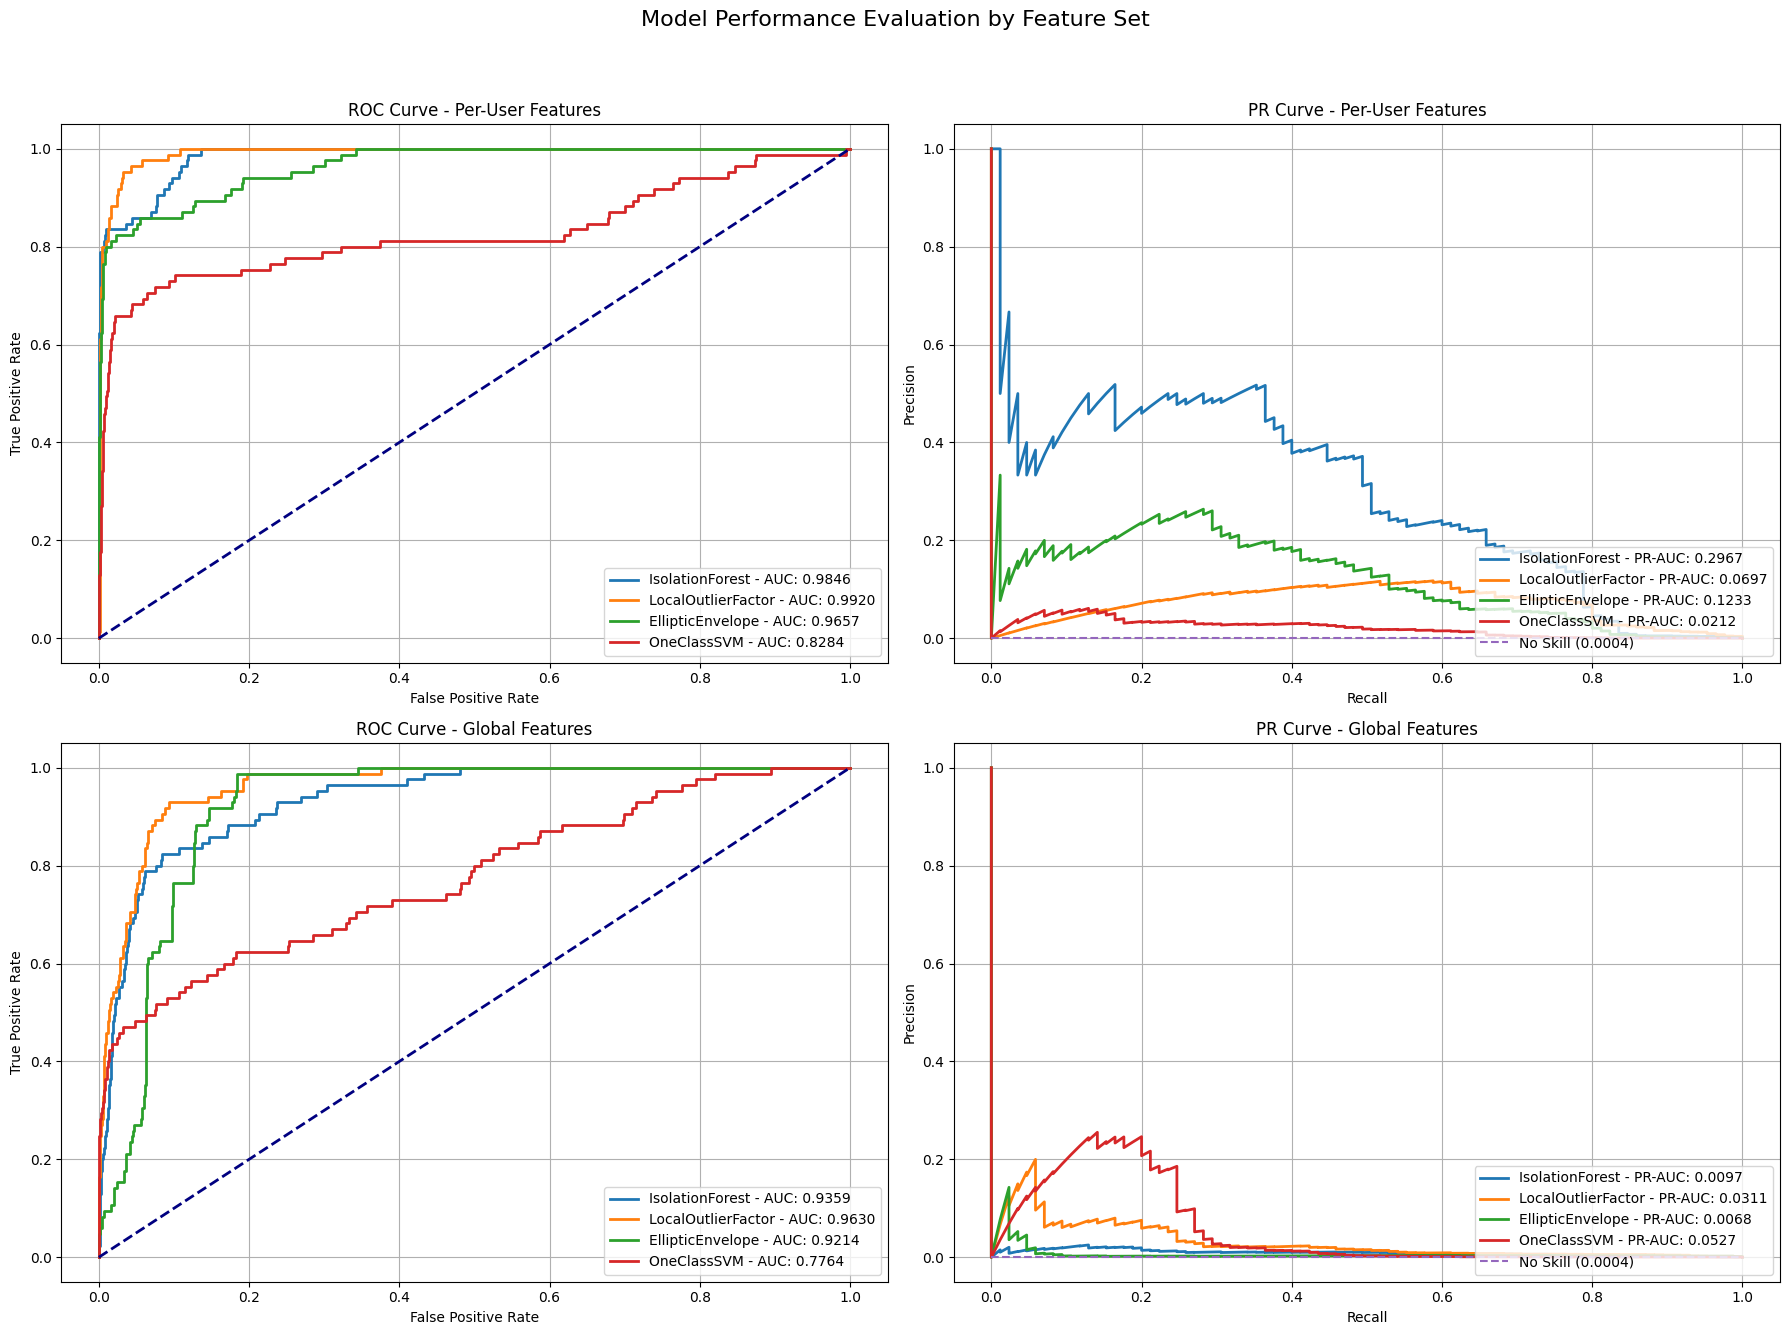

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- MODIFICATION: Set up a 2x2 grid for the subplots ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Model Performance Evaluation by Feature Set', fontsize=16)

# --- PLOT 1: ROC Curve for Per-User models ---
ax_roc_user = axes[0, 0]
per_user_results = [r for r in all_results if r['feature_set'] == 'per_user']
for result in per_user_results:
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_scores'])
    roc_auc = auc(fpr, tpr)
    ax_roc_user.plot(fpr, tpr, lw=2, label=f"{result['model']} - AUC: {roc_auc:.4f}")

ax_roc_user.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_roc_user.set_title('ROC Curve - Per-User Features')
ax_roc_user.set_xlabel('False Positive Rate')
ax_roc_user.set_ylabel('True Positive Rate')
ax_roc_user.legend(loc="lower right")
ax_roc_user.grid(True)

# --- PLOT 2: PR Curve for Per-User models ---
ax_pr_user = axes[0, 1]
for result in per_user_results:
    precision, recall, _ = precision_recall_curve(result['y_true'], result['y_scores'])
    pr_auc = result['pr_auc']
    ax_pr_user.plot(recall, precision, lw=2, label=f"{result['model']} - PR-AUC: {pr_auc:.4f}")

no_skill = len(test_user[test_user['is_malicious']==1]) / len(test_user)
ax_pr_user.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ({no_skill:.4f})')
ax_pr_user.set_title('PR Curve - Per-User Features')
ax_pr_user.set_xlabel('Recall')
ax_pr_user.set_ylabel('Precision')
ax_pr_user.legend(loc="lower right")
ax_pr_user.grid(True)

# --- PLOT 3: ROC Curve for Global models ---
ax_roc_global = axes[1, 0]
global_results = [r for r in all_results if r['feature_set'] == 'global']
for result in global_results:
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_scores'])
    roc_auc = auc(fpr, tpr)
    ax_roc_global.plot(fpr, tpr, lw=2, label=f"{result['model']} - AUC: {roc_auc:.4f}")

ax_roc_global.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_roc_global.set_title('ROC Curve - Global Features')
ax_roc_global.set_xlabel('False Positive Rate')
ax_roc_global.set_ylabel('True Positive Rate')
ax_roc_global.legend(loc="lower right")
ax_roc_global.grid(True)

# --- PLOT 4: PR Curve for Global models ---
ax_pr_global = axes[1, 1]
for result in global_results:
    precision, recall, _ = precision_recall_curve(result['y_true'], result['y_scores'])
    pr_auc = result['pr_auc']
    ax_pr_global.plot(recall, precision, lw=2, label=f"{result['model']} - PR-AUC: {pr_auc:.4f}")

ax_pr_global.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ({no_skill:.4f})')
ax_pr_global.set_title('PR Curve - Global Features')
ax_pr_global.set_xlabel('Recall')
ax_pr_global.set_ylabel('Precision')
ax_pr_global.legend(loc="lower right")
ax_pr_global.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

CELL 7 — Step 4: IsolationForest experiment matrix (4 scenarios): Global vs Per-user normalization and Global vs Per-user thresholding

In [8]:
# Helper to fit IF on a given training feature set and return scores for a test set
def fit_if_and_score(X_train, X_test, random_state=RANDOM_STATE):
    clf = IsolationForest(n_estimators=500,
    contamination='auto',
    max_features=0.5,
    random_state=42,
    n_jobs=-1)
    clf.fit(X_train)
    scores = safe_anomaly_scores_from_clf(clf, X_test)
    return clf, scores

# Helper to compute per-user thresholds from training pool (benign-only)
def per_user_thresholds_from_benign(clf, X_train_pool_df, train_pool_df, pct=PCT_THRESHOLD, min_samples=MIN_USER_SAMPLES_FOR_PER_USER):
    # X_train_pool_df: DataFrame aligned with train_pool_df
    train_scores = -clf.decision_function(X_train_pool_df)  # ensure alignment: higher -> anomalous
    train_pool_df_local = train_pool_df.copy().reset_index(drop=True)
    train_pool_df_local['anomaly_score'] = train_scores
    global_threshold = np.percentile(train_scores, pct)
    pupct = pct / 100.0
    grouped = train_pool_df_local.groupby('user')['anomaly_score']
    counts = grouped.count()
    per_user_thresh = grouped.quantile(pupct)
    per_user_thresh = per_user_thresh.where(counts >= min_samples)
    # return Series mapping user->threshold and global_threshold fallback
    return per_user_thresh, global_threshold

def predict_using_thresholds(scores_array, test_df_local, per_user_thresh_series, global_threshold):
    # scores_array aligned with test_df_local index
    tmp = test_df_local.copy().reset_index(drop=True)
    tmp['anomaly_score'] = scores_array
    tmp['anomaly_threshold'] = tmp['user'].map(per_user_thresh_series).fillna(global_threshold)
    tmp['is_model_anomaly'] = (tmp['anomaly_score'] >= tmp['anomaly_threshold']).astype(int)
    return tmp

# Experiment matrix combinations
# normalization: 'global' uses global_z_cols; 'per_user' uses per_user_z_cols
# thresholding: 'global_thr' uses global percentile on training pool; 'per_user_thr' uses per-user percentiles

scenarios = []
norm_types = ['global', 'per_user']
thr_types = ['global_thr', 'per_user_thr']
pct_list = [98, 99, 99.5, 99.9]

# Prebuild training & test feature matrices aligned to train/test DataFrames:
# For per-user normalization we'll use per-user features; for global normalization use global features.

X_train_user_all = _build_X(train_user, per_user_z_cols)
X_test_user_all  = _build_X(test_user, per_user_z_cols)
X_train_global_all = _build_X(train_global, global_z_cols)
X_test_global_all  = _build_X(test_global, global_z_cols)

# We'll evaluate IF on the four combos for a default pct=PCT_THRESHOLD (e.g., 99)
eval_records = []

for norm in norm_types:
    for thr in thr_types:
        # select training/test X
        if norm == 'global':
            X_train_pool = X_train_global_all.loc[train_ben_global_idx]  # benign-only for fitting
            X_train_full = X_train_global_all
            X_test = X_test_global_all
            train_pool_df = train_global.loc[train_ben_global_idx].reset_index(drop=True)
            test_df_local = test_global.reset_index(drop=True)
        else:
            X_train_pool = X_train_user_ben
            X_train_full = X_train_user_all
            X_test = X_test_user_all
            train_pool_df = train_user.loc[train_ben_user_idx].reset_index(drop=True)
            test_df_local = test_user.reset_index(drop=True)

        # Fit IF on benign training pool
        clf, scores_test = fit_if_and_score(X_train_pool, X_test)

        # If thresholding method is global_thr -> compute global threshold on train_pool; if per_user_thr -> compute per-user thresholds
        if thr == 'global_thr':
            global_thr = np.percentile(-clf.decision_function(X_train_pool), PCT_THRESHOLD)
            tmp = test_df_local.copy().reset_index(drop=True)
            tmp['anomaly_score'] = scores_test
            tmp['is_model_anomaly'] = (tmp['anomaly_score'] >= global_thr).astype(int)
        else:
            per_user_thresh_series, global_thr = per_user_thresholds_from_benign(clf, X_train_pool, train_pool_df, pct=PCT_THRESHOLD)
            tmp = predict_using_thresholds(scores_test, test_df_local, per_user_thresh_series, global_thr)

        # Evaluate metrics & ROC/PR-AUC
        y_true = tmp['is_malicious'].astype(int).values
        y_pred = tmp['is_model_anomaly'].astype(int).values
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        metrics = compute_metrics_from_cm(cm)
        try:
            roc = roc_auc_score(y_true, tmp['anomaly_score'])
        except:
            roc = float('nan')
        try:
            pr = average_precision_score(y_true, tmp['anomaly_score'])
        except:
            pr = float('nan')

        eval_records.append({
            'norm': norm,
            'thr': thr,
            'pct_used': PCT_THRESHOLD,
            'tn': metrics['tn'], 'fp': metrics['fp'], 'fn': metrics['fn'], 'tp': metrics['tp'],
            'accuracy': metrics['accuracy'], 'precision': metrics['precision'],
            'recall': metrics['recall'], 'f1': metrics['f1'],
            'roc_auc': roc, 'pr_auc': pr
        })

eval_if_df = pd.DataFrame(eval_records).sort_values(['f1'], ascending=False).reset_index(drop=True)
print("\n=== IsolationForest experiment matrix (norm vs threshold) at pct=", PCT_THRESHOLD)
display(eval_if_df.round(4))

# Sensitivity to percentile thresholds (per-user threshold case)
sensitivity_rows = []
for pct in pct_list:
    # pick normalization = per_user, threshold = per_user_thr (you can repeat for other combos similarly)
    X_train_pool = X_train_user_ben
    X_test = X_test_user_all
    train_pool_df_local = train_user.loc[train_ben_user_idx].reset_index(drop=True)
    clf, scores_test = fit_if_and_score(X_train_pool, X_test)
    per_user_thresh_series, global_thr = per_user_thresholds_from_benign(clf, X_train_pool, train_pool_df_local, pct=pct)
    tmp = predict_using_thresholds(scores_test, test_user.reset_index(drop=True), per_user_thresh_series, global_thr)
    y_true = tmp['is_malicious'].astype(int).values
    cm = confusion_matrix(y_true, tmp['is_model_anomaly'].astype(int).values, labels=[0,1])
    m = compute_metrics_from_cm(cm)
    sensitivity_rows.append({'pct': pct, **m})

sensitivity_df = pd.DataFrame(sensitivity_rows)
print("\nPer-user threshold sensitivity (per-user features + per-user threshold):")
display(sensitivity_df.round(4))


=== IsolationForest experiment matrix (norm vs threshold) at pct= 99


,norm,thr,pct_used,tn,fp,fn,tp,accuracy,precision,recall,f1,roc_auc,pr_auc
0,per_user,global_thr,99,197819,1878,15,70,0.9905,0.0359,0.8235,0.0689,0.9846,0.2967
1,global,per_user_thr,99,197543,2154,14,71,0.9891,0.0319,0.8353,0.0615,0.9359,0.0097
2,per_user,per_user_thr,99,197059,2638,6,79,0.9868,0.0291,0.9294,0.0564,0.9846,0.2967
3,global,global_thr,99,197591,2106,63,22,0.9891,0.0103,0.2588,0.0199,0.9359,0.0097



Per-user threshold sensitivity (per-user features + per-user threshold):


,pct,accuracy,precision,recall,f1,tn,fp,fn,tp
0,98.0,0.9785,0.0185,0.9529,0.0364,195407,4290,4,81
1,99.0,0.9868,0.0291,0.9294,0.0564,197059,2638,6,79
2,99.5,0.9916,0.0433,0.8941,0.0826,198018,1679,9,76
3,99.9,0.9942,0.0611,0.8824,0.1143,198545,1152,10,75


CELL 8 — Run baseline and other adaptive scenarios

In [9]:
# We'll use the per-user feature set and per-user thresholding logic here (as requested).
# Use the initial benign-only training pool (before split) as warm start.

init_train_ben = train_user[train_user['is_malicious'] == 0].copy()
if init_train_ben.empty:
    raise ValueError("Benign-only training partition at/before split is empty.")

# Include rule flag columns in the initial training pool dataframe
# This ensures the dataframe schema is consistent during retraining.
X_init_train_pool = _build_X(init_train_ben, per_user_z_cols)
train_pool_df_init = init_train_ben[ID_COLS + LABEL_COLS + RULE_FLAG_NAMES].copy().reset_index(drop=True)

def _init_if_and_pool():
    X_train_pool_local = X_init_train_pool.copy()
    train_pool_df_local = train_pool_df_init.copy()
    clf_local = clf = IsolationForest(n_estimators=500,
                    contamination='auto',
                    max_features=0.5,
                    random_state=42,
                    n_jobs=-1)
    clf_local.fit(X_train_pool_local)
    return clf_local, X_train_pool_local, train_pool_df_local

# prepare months to iterate
first_test_month_start = pd.Timestamp(f"{split_year}-07-01")
test_days = test_user['day']
all_month_starts = sorted({_month_start(x) for x in test_days if x >= first_test_month_start})

def run_monthly_scenario(mode):
    """
    mode in {"holdout", "expand_tnfpfn", "expand_tnfp"}
    This is a general function for the non-FP-only scenarios.
    """
    clf, X_train_pool, train_pool_df = _init_if_and_pool()
    cumulative_cm = np.array([[0,0],[0,0]], dtype=int)

    for m_start in all_month_starts:
        m_end = _month_end_exclusive(m_start)
        month_mask = (test_user['day'] >= m_start) & (test_user['day'] < m_end)
        test_month_df = test_user.loc[month_mask].copy()
        if test_month_df.empty:
            continue

        X_test_month = _build_X(test_month_df, per_user_z_cols)
        test_scores = safe_anomaly_scores_from_clf(clf, X_test_month)

        per_user_thresh_series, global_thr = per_user_thresholds_from_benign(clf, X_train_pool, train_pool_df, pct=PCT_THRESHOLD, min_samples=MIN_USER_SAMPLES_FOR_PER_USER)
        test_month_scored = predict_using_thresholds(test_scores, test_month_df.reset_index(drop=True), per_user_thresh_series, global_thr)

        y_true = test_month_scored['is_malicious'].astype(int).values
        y_pred = test_month_scored['is_model_anomaly'].astype(int).values
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        cumulative_cm += cm

        if mode != 'holdout':
            is_benign = (test_month_scored['is_malicious'].astype(int) == 0)
            is_mal    = (test_month_scored['is_malicious'].astype(int) == 1)
            is_alert  = (test_month_scored['is_model_anomaly'].astype(int) == 1)
            mask_TN = is_benign & (~is_alert)
            mask_FP = is_benign & (is_alert)
            mask_FN = is_mal & (~is_alert)

            if mode == "expand_tnfpfn":
                retrain_keep_mask = mask_TN | mask_FP | mask_FN
            elif mode == "expand_tnfp":
                retrain_keep_mask = mask_TN | mask_FP
            else:
                raise ValueError("Unknown mode")

            retrain_add_df = test_month_scored.loc[retrain_keep_mask, ID_COLS + LABEL_COLS + RULE_FLAG_NAMES].copy()
            if not retrain_add_df.empty:
                train_pool_df = pd.concat([train_pool_df, retrain_add_df], axis=0, ignore_index=True)
                train_pool_df.drop_duplicates(subset=ID_COLS, keep='last', inplace=True)

                cur_train_merge = train_pool_df.merge(df_user[ID_COLS + per_user_z_cols], on=ID_COLS, how='left').dropna(subset=per_user_z_cols)
                if cur_train_merge.empty:
                    print("Warning: cur_train_merge empty. Skipping retrain for this month.")
                else:
                    X_train_pool = _build_X(cur_train_merge, per_user_z_cols)
                    train_pool_df = cur_train_merge[ID_COLS + LABEL_COLS + RULE_FLAG_NAMES].copy().reset_index(drop=True)
                    clf = IsolationForest(n_estimators=500,
                    contamination='auto',
                    max_features=0.5,
                    random_state=42,
                    n_jobs=-1)
                    clf.fit(X_train_pool)

    return cumulative_cm

def print_cm_summary(name, cm):
    m = compute_metrics_from_cm(cm)
    print(f"\n=== {name} ===")
    print("CM:", cm)
    print(f"Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}, F1: {m['f1']:.4f}, TP:{m['tp']}, FP:{m['fp']}")


print("Running baseline and other adaptive scenarios...")
cm_holdout = run_monthly_scenario("holdout")
cm_expand_all = run_monthly_scenario("expand_tnfpfn")
cm_expand_tnfp = run_monthly_scenario("expand_tnfp")

print_cm_summary("Holdout", cm_holdout)
print_cm_summary("Expand TN/FP/FN", cm_expand_all)
print_cm_summary("Expand TN/FP", cm_expand_tnfp)

Running baseline and other adaptive scenarios...

=== Holdout ===
CM: [[197059   2638]
 [     6     79]]
Precision: 0.0291, Recall: 0.9294, F1: 0.0564, TP:79, FP:2638

=== Expand TN/FP/FN ===
CM: [[197297   2400]
 [     6     79]]
Precision: 0.0319, Recall: 0.9294, F1: 0.0616, TP:79, FP:2400

=== Expand TN/FP ===
CM: [[197273   2424]
 [     7     78]]
Precision: 0.0312, Recall: 0.9176, F1: 0.0603, TP:78, FP:2424


CELL 9 — Run 'Expand FP-only' scenario with monthly SHAP, Rule, and Hybrid Score calculation

In [10]:
print("Running 'Expand FP-only' scenario with detailed monthly scoring...")

# --- Dedicated Monthly Loop for FP-Only Scenario ---
clf, X_train_pool, train_pool_df = _init_if_and_pool()
cumulative_cm_fp = np.array([[0,0],[0,0]], dtype=int)
all_results_fp = []
COLS_TO_KEEP = ID_COLS + ['is_malicious', 'anomaly_score', 'is_model_anomaly', 'rule_score', 'hybrid_score', 'shap_explanation']

# Set weights, which are constant
w1 = HYBRID_WEIGHT_MODEL
w2 = 1.0 - w1

for m_start in all_month_starts:
    m_end = _month_end_exclusive(m_start)
    month_mask = (test_user['day'] >= m_start) & (test_user['day'] < m_end)
    test_month_df = test_user.loc[month_mask].copy()
    if test_month_df.empty:
        continue

    # --- Scoring & Thresholding ---
    X_test_month = _build_X(test_month_df, per_user_z_cols)
    test_scores = safe_anomaly_scores_from_clf(clf, X_test_month)
    per_user_thresh_series, global_thr = per_user_thresholds_from_benign(clf, X_train_pool, train_pool_df, pct=PCT_THRESHOLD, min_samples=MIN_USER_SAMPLES_FOR_PER_USER)
    test_month_scored = predict_using_thresholds(test_scores, test_month_df.reset_index(drop=True), per_user_thresh_series, global_thr)

    # --- CHANGE: Single call for Rules and SHAP ---
    if DO_SHAP_MONTHLY:
        test_month_scored = _attach_monthly_shap_and_rule(clf, X_train_pool, test_month_scored, per_user_z_cols)
    else:
        test_month_scored['rule_score'] = test_month_scored.apply(compute_rule_score_row, axis=1)
        max_possible_rule = sum(w for w in RULE_WEIGHTS.values() if w > 0) or 1.0
        test_month_scored['rule_norm'] = (test_month_scored['rule_score'] / max_possible_rule).clip(0.0, 1.0)
        test_month_scored['shap_explanation'] = ''

    # --- MODIFIED LOGIC STARTS HERE ---
    # 1. Recalculate min/max anomaly scores based on the CURRENT training pool
    current_train_scores = safe_anomaly_scores_from_clf(clf, X_train_pool)
    score_min, score_max = current_train_scores.min(), current_train_scores.max()

    # 2. Use these new min/max values for normalization and hybrid score calculation
    anomaly_norm = ((test_month_scored['anomaly_score'] - score_min) / (score_max - score_min)).clip(0, 1)
    test_month_scored['hybrid_score'] = (w1 * anomaly_norm) + (w2 * test_month_scored['rule_norm'])
    # --- MODIFIED LOGIC ENDS HERE ---

    # --- Accumulate Metrics and Results ---
    y_true = test_month_scored['is_malicious'].astype(int).values
    y_pred = test_month_scored['is_model_anomaly'].astype(int).values
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    cumulative_cm_fp += cm
    all_results_fp.append(test_month_scored[COLS_TO_KEEP].copy())

    # --- Retraining Logic ---
    is_benign = (test_month_scored['is_malicious'].astype(int) == 0)
    is_alert  = (test_month_scored['is_model_anomaly'].astype(int) == 1)
    mask_FP = is_benign & is_alert

    retrain_add_df = test_month_scored.loc[mask_FP, ID_COLS + LABEL_COLS + RULE_FLAG_NAMES].copy()
    if not retrain_add_df.empty:
        train_pool_df = pd.concat([train_pool_df, retrain_add_df], axis=0, ignore_index=True)
        train_pool_df.drop_duplicates(subset=ID_COLS, keep='last', inplace=True)

        cur_train_merge = train_pool_df.merge(df_user[ID_COLS + per_user_z_cols], on=ID_COLS, how='left').dropna(subset=per_user_z_cols)
        if cur_train_merge.empty:
            print("Warning: cur_train_merge empty. Skipping retrain for this month.")
        else:
            X_train_pool = _build_X(cur_train_merge, per_user_z_cols)
            train_pool_df = cur_train_merge[ID_COLS + LABEL_COLS + RULE_FLAG_NAMES].copy().reset_index(drop=True)
            clf = IsolationForest(n_estimators=500, contamination='auto', max_features=0.5, random_state=42, n_jobs=-1)
            clf.fit(X_train_pool)

# Concatenate all monthly results
results_fp_only = pd.concat(all_results_fp, axis=0, ignore_index=True) if len(all_results_fp) > 0 else pd.DataFrame()

# Print Final Cumulative Metrics for this scenario
print_cm_summary("Expand FP-only", cumulative_cm_fp)
print(f"\nCompleted. Final DataFrame 'results_fp_only' has {len(results_fp_only)} rows and is ready for analysis in the next cell.")

Running 'Expand FP-only' scenario with detailed monthly scoring...

=== Expand FP-only ===
CM: [[197934   1763]
 [     6     79]]
Precision: 0.0429, Recall: 0.9294, F1: 0.0820, TP:79, FP:1763

Completed. Final DataFrame 'results_fp_only' has 199782 rows and is ready for analysis in the next cell.


CELL 10 — Final Budget Analysis for 'Expand FP-only' Alerts

In [11]:
if 'results_fp_only' in locals() and not results_fp_only.empty:
    print("\n" + "="*80)
    print("ANALYSIS OF 'EXPAND FP-ONLY' SCENARIO ALERTS")
    print("="*80)

    # 1. Prepare the alerts DataFrame from the results
    alerts_df = results_fp_only[results_fp_only['is_model_anomaly'] == 1].copy()
    total_tp = int(results_fp_only['is_malicious'].sum())
    total_model_alerts = len(alerts_df)

    print(f"Total true positives in the test set: {total_tp}")
    print(f"Total model-detected anomalies to analyze: {total_model_alerts}\n")

    if total_model_alerts > 0:
        # 2. Model-Score Ranking Budget Analysis
        model_ranked_alerts = alerts_df.sort_values('anomaly_score', ascending=False).reset_index(drop=True)

        print("--- Model-Score Ranking Budget Analysis ---")
        print(f"{'Top-%':>8} | {'Top-N':>6} | {'Precision in Budget':>20} | {'% of All TPs Covered':>22} | {'# TPs in Budget':>16}")
        print("-" * 80)

        percent_budgets = [1.0, 2.0, 5.0, 10.0]
        for p in percent_budgets:
            k = max(1, int(np.floor(p/100 * total_model_alerts)))
            head = model_ranked_alerts.head(k)
            tp_in_budget = int(head['is_malicious'].sum())
            precision = (tp_in_budget / k * 100.0) if k > 0 else 0.0
            coverage = (tp_in_budget / total_tp * 100.0) if total_tp > 0 else 0.0
            print(f"{p:7.2f}% | {k:6d} | {precision:19.2f}% | {coverage:21.2f}% | {tp_in_budget:15d}")

        # 3. Hybrid-Score Re-ranking Budget Analysis
        # The hybrid_score was already calculated monthly in the previous cell
        print("\n--- Hybrid-Score Re-ranking Analysis ---")
        hybrid_ranked_alerts = alerts_df.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

        print(f"{'Top-%':>8} | {'Top-N':>6} | {'Precision in Budget':>20} | {'% of All TPs Covered':>22} | {'# TPs in Budget':>16}")
        print("-" * 80)

        for p in percent_budgets:
            k = max(1, int(np.floor(p/100 * total_model_alerts)))
            head = hybrid_ranked_alerts.head(k)
            tp_in_budget = int(head['is_malicious'].sum())
            precision = (tp_in_budget / k * 100.0) if k > 0 else 0.0
            coverage = (tp_in_budget / total_tp * 100.0) if total_tp > 0 else 0.0
            print(f"{p:7.2f}% | {k:6d} | {precision:19.2f}% | {coverage:21.2f}% | {tp_in_budget:15d}")

        # 4. Display top alerts from hybrid ranking
        print("\nTop 10 alerts after Hybrid Re-ranking:")
        display_cols = ['user', 'day', 'hybrid_score', 'anomaly_score', 'rule_score', 'is_malicious', 'shap_explanation']
        display(hybrid_ranked_alerts.head(10)[display_cols])

    else:
        print("No model-detected anomalies were found to analyze in the 'expand_fp_only' scenario.")

else:
    print("Variable 'results_fp_only' not found or is empty. Please run Cell 9 successfully before this one.")


ANALYSIS OF 'EXPAND FP-ONLY' SCENARIO ALERTS
Total true positives in the test set: 85
Total model-detected anomalies to analyze: 1842

--- Model-Score Ranking Budget Analysis ---
   Top-% |  Top-N |  Precision in Budget |   % of All TPs Covered |  # TPs in Budget
--------------------------------------------------------------------------------
   1.00% |     18 |               38.89% |                  8.24% |               7
   2.00% |     36 |               41.67% |                 17.65% |              15
   5.00% |     92 |               41.30% |                 44.71% |              38
  10.00% |    184 |               27.72% |                 60.00% |              51

--- Hybrid-Score Re-ranking Analysis ---
   Top-% |  Top-N |  Precision in Budget |   % of All TPs Covered |  # TPs in Budget
--------------------------------------------------------------------------------
   1.00% |     18 |              100.00% |                 21.18% |              18
   2.00% |     36 |       

,user,day,hybrid_score,anomaly_score,rule_score,is_malicious,shap_explanation
0,CAH0936,2010-08-11,1.000000,0.232256,2.3,1,"[{""feature"": ""total_http_requests_user_z_7d"", ..."
1,JMB0308,2010-07-14,0.999438,0.206930,2.3,1,"[{""feature"": ""total_http_requests_user_z_7d"", ..."
2,EHD0584,2010-10-07,0.988222,0.220882,2.3,1,"[{""feature"": ""total_http_requests_user_z_7d"", ..."
3,EHB0824,2010-07-28,0.980365,0.196113,2.3,1,"[{""feature"": ""total_http_requests_user_z_7d"", ..."
4,EHD0584,2010-10-02,0.977691,0.214589,2.3,1,"[{""feature"": ""afterhours_usb_connects_user_z"",..."
5,KPC0073,2010-07-07,0.969365,0.189875,2.3,1,"[{""feature"": ""afterhours_usb_connects_user_z"",..."
6,HJB0742,2010-11-25,0.962016,0.207494,2.3,1,"[{""feature"": ""afterhours_usb_connects_user_z"",..."
7,AAM0658,2010-10-29,0.953704,0.200254,2.3,1,"[{""feature"": ""total_http_requests_user_z_7d"", ..."
8,WDD0366,2011-02-24,0.950627,0.205023,2.3,1,"[{""feature"": ""afterhours_usb_connects_user_z"",..."
9,MAS0025,2010-09-29,0.944590,0.193333,2.3,1,"[{""feature"": ""total_http_requests_user_z_7d"", ..."


CELL 11 — Precision@K Curve for FP-Only Scenario Rankings

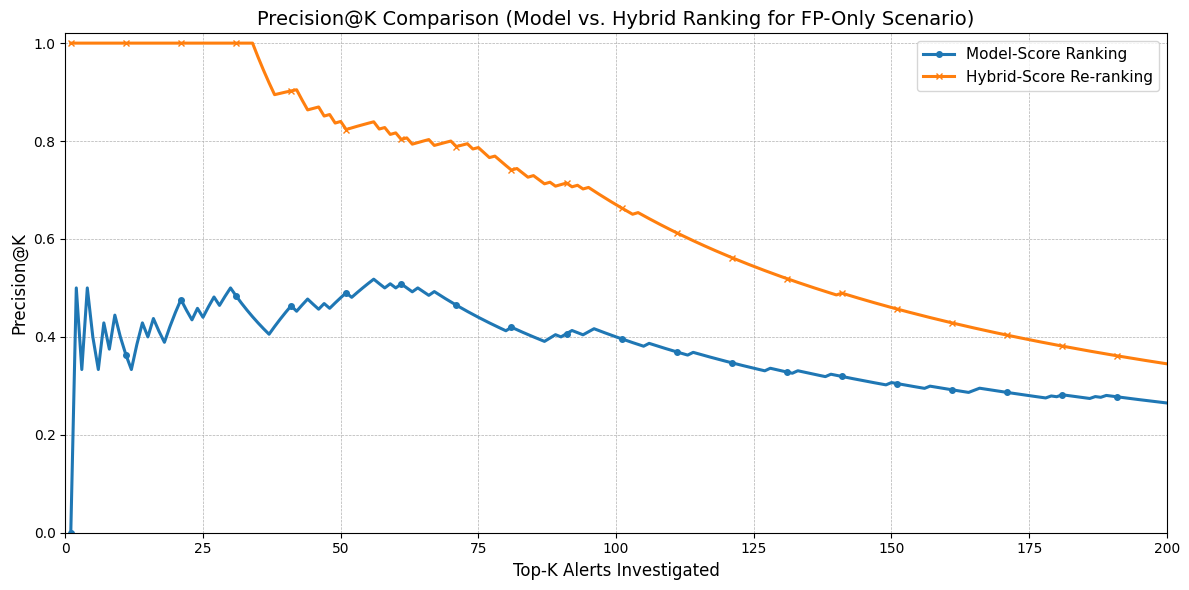

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Safety checks to ensure the required DataFrames from Cell 10 exist ---
for name in ['model_ranked_alerts', 'hybrid_ranked_alerts']:
    if name not in locals() or not isinstance(locals()[name], pd.DataFrame):
        raise RuntimeError(f"DataFrame '{name}' not found. Please run Cell 10 successfully before this one.")

# The provided script uses generic names 'model_anoms' and 'anomalies_all'.
# We will use the specific dataframes generated in Cell 10.
model_anoms = model_ranked_alerts
anomalies_all = hybrid_ranked_alerts

# --- Calculate Cumulative True Positives for each ranking method ---
# The 'is_malicious' column is already guaranteed to be in these DataFrames from Cell 10.
cum_tp_model = model_anoms['is_malicious'].astype(int).cumsum().to_numpy()
cum_tp_hybrid = anomalies_all['is_malicious'].astype(int).cumsum().to_numpy()

len_model = len(model_anoms)
len_hybrid = len(anomalies_all)

# --- Calculate Precision@K for K from 1 to 200 ---
MAX_K = 200
# Ensure ks does not exceed the number of available alerts to avoid index errors
ks = np.arange(1, min(MAX_K + 1, len_model + 1))

# For k > length of list, the precision is the total TPs found divided by k.
prec_model = np.array([ (cum_tp_model[k-1] / k) if k <= len_model else (cum_tp_model[-1] / k if len_model>0 else 0.0)
                        for k in ks ])
prec_hybrid = np.array([ (cum_tp_hybrid[k-1] / k) if k <= len_hybrid else (cum_tp_hybrid[-1] / k if len_hybrid>0 else 0.0)
                         for k in ks ])

# --- Create the Plot ---
plt.figure(figsize=(12, 6))
plt.plot(ks, prec_model, linewidth=2.2, label='Model-Score Ranking', marker='o', markersize=4, markevery=10)
plt.plot(ks, prec_hybrid, linewidth=2.2, label='Hybrid-Score Re-ranking', marker='x', markersize=5, markevery=10)

plt.xlabel('Top-K Alerts Investigated', fontsize=12)
plt.ylabel('Precision@K', fontsize=12)
plt.title('Precision@K Comparison (Model vs. Hybrid Ranking for FP-Only Scenario)', fontsize=14)
plt.xlim(0, MAX_K)
plt.ylim(0, 1.02)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', frameon=True, fontsize=11)
plt.tight_layout()
plt.show()